In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

try:
    # Attempt to read as Excel first
    try:
        df = pd.read_excel('/content/Rice_dataset.csv.xlsx')
        print("Dataset loaded successfully from Excel file!")
    except Exception as e:
        print(f"Could not read as Excel: {e}")
        # If reading as Excel fails, try reading as CSV with a different encoding
        try:
            df = pd.read_csv('/content/Rice_dataset.csv.xlsx', encoding='latin1')
            print("Dataset loaded successfully from CSV with latin1 encoding!")
        except FileNotFoundError:
            print("Error: File not found. Please place your file in the same directory.")
            exit()
        except Exception as e_csv:
            print(f"Could not read as CSV with latin1 encoding: {e_csv}")
            print("Error: Could not read the file with specified encodings. Please check the file format and encoding.")
            exit()

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_') # Clean column names
    print(df.head())

except Exception as e_general:
    print(f"An unexpected error occurred: {e_general}")
    exit()

Dataset loaded successfully from Excel file!
  unnamed:_0 crop_type soil_type  soil_ph  temperature  humidity  wind_speed  \
0 2014-01-01    Barley     Sandy     6.75    19.751848      80.0    2.682683   
1 2014-01-02    Barley    Saline     8.00    11.400779      80.0   11.382449   
2 2014-01-03    Barley     Loamy     6.50    18.718556      80.0   12.114944   
3 2014-01-04    Barley    Saline     8.00    16.724512      80.0   13.711048   
4 2014-01-05    Barley     Loamy     6.50    17.507982      80.0    8.195808   

      n     p     k  crop_yield  soil_quality  
0  50.0  40.0  30.0   58.939796         35.00  
1  65.0  55.0  45.0    8.159006         13.75  
2  70.0  60.0  50.0   81.299066         60.00  
3  65.0  55.0  45.0   33.294459         13.75  
4  70.0  60.0  50.0   61.851108         60.00  


In [5]:
for col in df.columns:
    if df[col].dtype == 'object': # Categorical
        df[col].fillna(df[col].mode()[0], inplace=True)
    else: # Numerical
        df[col].fillna(df[col].mean(), inplace=True)

/tmp/ipython-input-5-3579737520.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-5-3579737520.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [6]:
df['optimal_irrigation_mm'] = (
    10 +                            # Base irrigation
    0.5 * df['temperature'] -       # Higher temp -> more water
    0.2 * df['humidity'] +          # Higher humidity -> less water
    0.1 * df['wind_speed'] -        # Higher wind -> more water
    0.05 * df['soil_quality'] +     # Lower quality soil -> more water (assuming lower value = higher quality)
    0.02 * df['crop_yield'] +       # Higher yield suggests good conditions, including irrigation
    np.random.normal(0, 2, len(df)) # Add some noise
)
df['optimal_irrigation_mm'] = df['optimal_irrigation_mm'].apply(lambda x: max(5, min(30, x))) # Keep in reasonable range

# One-hot encode categorical features (soil_type, crop_type)
categorical_cols = [col for col in ['soil_type', 'crop_type'] if col in df.columns]
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nData after preprocessing and synthetic target creation:")
print(df.head())


Data after preprocessing and synthetic target creation:
  unnamed:_0  soil_ph  temperature  humidity  wind_speed     n     p     k  \
0 2014-01-01     6.75    19.751848      80.0    2.682683  50.0  40.0  30.0   
1 2014-01-02     8.00    11.400779      80.0   11.382449  65.0  55.0  45.0   
2 2014-01-03     6.50    18.718556      80.0   12.114944  70.0  60.0  50.0   
3 2014-01-04     8.00    16.724512      80.0   13.711048  65.0  55.0  45.0   
4 2014-01-05     6.50    17.507982      80.0    8.195808  70.0  60.0  50.0   

   crop_yield  soil_quality  ...  soil_type_Sandy  crop_type_Corn  \
0   58.939796         35.00  ...             True           False   
1    8.159006         13.75  ...            False           False   
2   81.299066         60.00  ...            False           False   
3   33.294459         13.75  ...            False           False   
4   61.851108         60.00  ...            False           False   

   crop_type_Cotton  crop_type_Potato  crop_type_Rice  crop

In [13]:
X = df.drop(['optimal_irrigation_mm', 'crop_yield', 'unnamed:_0'], axis=1, errors='ignore')
y = df['optimal_irrigation_mm']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples.")


Training on 29215 samples, testing on 7304 samples.


In [15]:
model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1) # Fewer estimators for speed/simplicity
model.fit(X_train, y_train)
print("\nRandom Forest model trained.")


Random Forest model trained.


In [16]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"  Mean Squared Error (MSE): {mse:.2f}")
print(f"  R-squared (R2): {r2:.2f}")


Model Performance:
  Mean Squared Error (MSE): 2.50
  R-squared (R2): 0.85


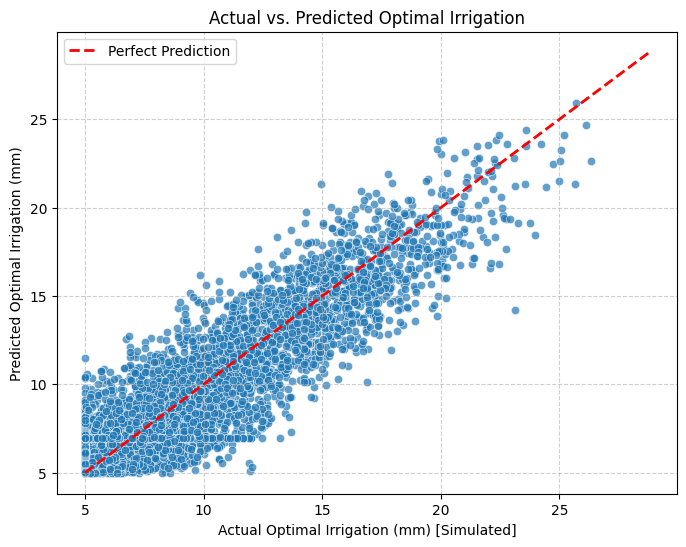


Code execution complete. Check the plot for visualization.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Optimal Irrigation (mm) [Simulated]")
plt.ylabel("Predicted Optimal Irrigation (mm)")
plt.title("Actual vs. Predicted Optimal Irrigation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nCode execution complete. Check the plot for visualization.")